# Lab 8: Implement Your Machine Learning Project Plan

In this lab assignment, you will implement the machine learning project plan you created in the written assignment. You will:

1. Load your data set and save it to a Pandas DataFrame.
2. Perform exploratory data analysis on your data to determine which feature engineering and data preparation techniques you will use.
3. Prepare your data for your model and create features and a label.
4. Fit your model to the training data and evaluate your model.
5. Improve your model by performing model selection and/or feature selection techniques to find best model for your problem.

### Import Packages

Before you get started, import a few packages.

In [1]:
import pandas as pd
import numpy as np
import os 
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

<b>Task:</b> In the code cell below, import additional packages that you have used in this course that you will need for this task.

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
import gensim
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression


## Part 1: Load the Data Set


You have chosen to work with one of four data sets.

* The book review data set is located in file `bookReviewsData.csv`



<b>Task:</b> In the code cell below, use the same method you have been using to load your data using `pd.read_csv()` and save it to DataFrame `df`.

In [20]:
filename = "bookReviewsData.csv"
df = pd.read_csv(filename, header=0)

## Part 2: Exploratory Data Analysis

The next step is to inspect and analyze your data set with your machine learning problem and project plan in mind. 

This step will help you determine data preparation and feature engineering techniques you will need to apply to your data to build a balanced modeling data set for your problem and model. These data preparation techniques may include:
* addressing missingness, such as replacing missing values with means
* renaming features and labels
* finding and replacing outliers
* performing winsorization if needed
* performing one-hot encoding on categorical features
* performing vectorization for an NLP problem
* addressing class imbalance in your data sample to promote fair AI


Think of the different techniques you have used to inspect and analyze your data in this course. These include using Pandas to apply data filters, using the Pandas `describe()` method to get insight into key statistics for each column, using the Pandas `dtypes` property to inspect the data type of each column, and using Matplotlib and Seaborn to detect outliers and visualize relationships between features and labels. If you are working on a classification problem, use techniques you have learned to determine if there is class imbalance.


<b>Task</b>: Use the techniques you have learned in this course to inspect and analyze your data. 

<b>Note</b>: You can add code cells if needed by going to the <b>Insert</b> menu and clicking on <b>Insert Cell Below</b> in the drop-drown menu.

In [4]:
# Checking if Data is balanced
print(df['Positive Review'].sum())
print(len(df) - df['Positive Review'].sum())

980
993


In [37]:
# Inspect head of the data
df.head()

,Review,Positive Review
0,I did not find this book very helpful. There i...,False
1,Clinton's old friend and key Russia advisor pr...,True
2,The novels in this series are not the escapist...,True
3,This book is as much about life as it is about...,True
4,I have been slogging through this book for wee...,False


In [25]:
positive_samples = df[df['Positive Review'] == 1]
negative_samples = df[df['Positive Review'] == 0]

# Oversample the positive class
oversampled_positive = positive_samples.sample(n=980, replace=True, random_state=123)

# Undersample the negative class to match the size of the positive class
undersampled_negative = negative_samples.sample(n=980, random_state=123)

# Concatenate the oversampled positive class with the undersampled negative class
df = pd.concat([oversampled_positive, undersampled_negative])

# Shuffle the dataset to ensure randomness
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Checking if Data is balanced
print(df['Positive Review'].sum())
print(len(df) - df['Positive Review'].sum())


980
980


In [26]:
# Ensuring no null values
df.isnull().any()

Review             False
Positive Review    False
dtype: bool

In [27]:
y = df['Positive Review']
X = df['Review']

# Transforming the text to features
original_X = X
X = X.apply(lambda row: gensim.utils.simple_preprocess(row))

X.head()

0    [did, not, find, this, book, very, helpful, th...
1    [clinton, old, friend, and, key, russia, advis...
2    [the, novels, in, this, series, are, not, the,...
3    [this, book, is, as, much, about, life, as, it...
4    [have, been, slogging, through, this, book, fo...
Name: Review, dtype: object

In [28]:
# Creating training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.80, random_state=1234)

X_train.head()

483     [have, yet, to, use, an, actual, phrase, from,...
760     [am, not, going, to, repeat, other, reviewers,...
1491    [ve, read, many, books, on, meditation, and, w...
593     [first, read, this, book, back, in, the, mid, ...
1115    [had, chance, to, read, this, book, cover, to,...
Name: Review, dtype: object

In [29]:
word2vec_model = gensim.models.Word2Vec(X_train,
                                   vector_size=100,
                                   window=5,
                                   min_count=2)

In [30]:
# Measure size of model
len(word2vec_model.wv.key_to_index)

9476

## Part 3: Implement Your Project Plan

<b>Task:</b> Use the rest of this notebook to carry out your project plan. You will:

1. Prepare your data for your model and create features and a label.
2. Fit your model to the training data and evaluate your model.
3. Improve your model by performing model selection and/or feature selection techniques to find best model for your problem.


Add code cells below and populate the notebook with commentary, code, analyses, results, and figures as you see fit.

In [31]:
# Convert features into training and testing set
words = set(word2vec_model.wv.index_to_key)

X_train = np.array([np.array([word2vec_model.wv[word] for word in words if word in training_example])
                        for training_example in X_train], dtype=object)

X_test = np.array([np.array([word2vec_model.wv[word] for word in words if word in training_example])
                        for training_example in X_test], dtype=object)


In [32]:
# Making a consistent set of features per example
X_train_feature_vector = []
for w in X_train:
    if w.size:
        X_train_feature_vector.append(w.mean(axis=0))
    else:
        X_train_feature_vector.append(np.zeros(100, dtype=float))
        
X_test_feature_vector = []
for w in X_test:
    if w.size:
        X_test_feature_vector.append(w.mean(axis=0))
    else:
        X_test_feature_vector.append(np.zeros(100, dtype=float))

In [33]:
roc_scores = []

# Model Selection
hyperparams = [2**n for n in range(0,8)]
hyperparams
best_md_score = 0

for md in hyperparams:
    
    model = DecisionTreeClassifier(max_depth = md, min_samples_leaf = 40)

    model.fit(X_train_feature_vector, y_train)
    # 2. Make predictions on the transformed test data using the predict_proba() method and 
    # save the values of the second column
    probability_predictions = model.predict_proba(X_test_feature_vector)[:,1]

    # 3. Make predictions on the transformed test data using the predict() method 
    class_label_predictions = model.predict(X_test_feature_vector)

    # 4. Compute the Area Under the ROC curve (AUC) for the test data. Note that this time we are using one 
    # function 'roc_auc_score()' to compute the auc rather than using both 'roc_curve()' and 'auc()' as we have 
    # done in the past
    auc = roc_auc_score(y_test, probability_predictions)
    print('Max Depth: {0} | AUC on the test data: {1:.4f}'.format(md,auc))
    
    best_md_score = max(best_md_score,auc)

roc_scores.append(best_md_score) 


Max Depth: 1 | AUC on the test data: 0.6517
Max Depth: 2 | AUC on the test data: 0.6678
Max Depth: 4 | AUC on the test data: 0.7526
Max Depth: 8 | AUC on the test data: 0.7916
Max Depth: 16 | AUC on the test data: 0.7949
Max Depth: 32 | AUC on the test data: 0.7949
Max Depth: 64 | AUC on the test data: 0.7949
Max Depth: 128 | AUC on the test data: 0.7949


In [34]:
hyperparams = [10**i for i in range(-10,10)]
accuracy_scores = []

best_C_score = 0

for c in hyperparams:
    
    model = LogisticRegression(C=c, max_iter = 10000)
    model.fit(X_train_feature_vector, y_train)
    # 2. Make predictions on the transformed test data using the predict_proba() method and 
    # save the values of the second column
    probability_predictions = model.predict_proba(X_test_feature_vector)[:,1]

    # 3. Make predictions on the transformed test data using the predict() method 
    class_label_predictions = model.predict(X_test_feature_vector)

    # 4. Compute the Area Under the ROC curve (AUC) for the test data. Note that this time we are using one 
    # function 'roc_auc_score()' to compute the auc rather than using both 'roc_curve()' and 'auc()' as we have 
    # done in the past
    auc = roc_auc_score(y_test, probability_predictions)
    print('C= {0} | AUC on the test data: {1:.4f}'.format(c,auc))
    
    best_C_score = max(best_C_score,auc)

roc_scores.append(best_C_score)  

C= 1e-10 | AUC on the test data: 0.6424
C= 1e-09 | AUC on the test data: 0.6424
C= 1e-08 | AUC on the test data: 0.6451
C= 1e-07 | AUC on the test data: 0.6451
C= 1e-06 | AUC on the test data: 0.6451
C= 1e-05 | AUC on the test data: 0.6451
C= 0.0001 | AUC on the test data: 0.6451
C= 0.001 | AUC on the test data: 0.6459
C= 0.01 | AUC on the test data: 0.6478
C= 0.1 | AUC on the test data: 0.6625
C= 1 | AUC on the test data: 0.7109
C= 10 | AUC on the test data: 0.7576
C= 100 | AUC on the test data: 0.7894
C= 1000 | AUC on the test data: 0.8217
C= 10000 | AUC on the test data: 0.8376
C= 100000 | AUC on the test data: 0.8388
C= 1000000 | AUC on the test data: 0.8396
C= 10000000 | AUC on the test data: 0.8396
C= 100000000 | AUC on the test data: 0.8393
C= 1000000000 | AUC on the test data: 0.8392


In [35]:
hyperparams = [n for n in range(1,50,2)]
hyperparams
best_k_score = 0

for k in hyperparams:
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(X_train_feature_vector, y_train)
    # 2. Make predictions on the transformed test data using the predict_proba() method and 
    # save the values of the second column
    probability_predictions = model.predict_proba(X_test_feature_vector)[:,1]

    # 3. Make predictions on the transformed test data using the predict() method 
    class_label_predictions = model.predict(X_test_feature_vector)

    # 4. Compute the Area Under the ROC curve (AUC) for the test data. Note that this time we are using one 
    # function 'roc_auc_score()' to compute the auc rather than using both 'roc_curve()' and 'auc()' as we have 
    # done in the past
    auc = roc_auc_score(y_test, probability_predictions)
    print('Neighbors= {0} | AUC on the test data: {1:.4f}'.format(k,auc))
    best_k_score = max(best_k_score,auc)

roc_scores.append(best_k_score) 

Neighbors= 1 | AUC on the test data: 0.9130
Neighbors= 3 | AUC on the test data: 0.9035
Neighbors= 5 | AUC on the test data: 0.8738
Neighbors= 7 | AUC on the test data: 0.8379
Neighbors= 9 | AUC on the test data: 0.8205
Neighbors= 11 | AUC on the test data: 0.8004
Neighbors= 13 | AUC on the test data: 0.7783
Neighbors= 15 | AUC on the test data: 0.7700
Neighbors= 17 | AUC on the test data: 0.7740
Neighbors= 19 | AUC on the test data: 0.7741
Neighbors= 21 | AUC on the test data: 0.7719
Neighbors= 23 | AUC on the test data: 0.7602
Neighbors= 25 | AUC on the test data: 0.7565
Neighbors= 27 | AUC on the test data: 0.7572
Neighbors= 29 | AUC on the test data: 0.7538
Neighbors= 31 | AUC on the test data: 0.7499
Neighbors= 33 | AUC on the test data: 0.7447
Neighbors= 35 | AUC on the test data: 0.7491
Neighbors= 37 | AUC on the test data: 0.7456
Neighbors= 39 | AUC on the test data: 0.7460
Neighbors= 41 | AUC on the test data: 0.7483
Neighbors= 43 | AUC on the test data: 0.7537
Neighbors= 45 |

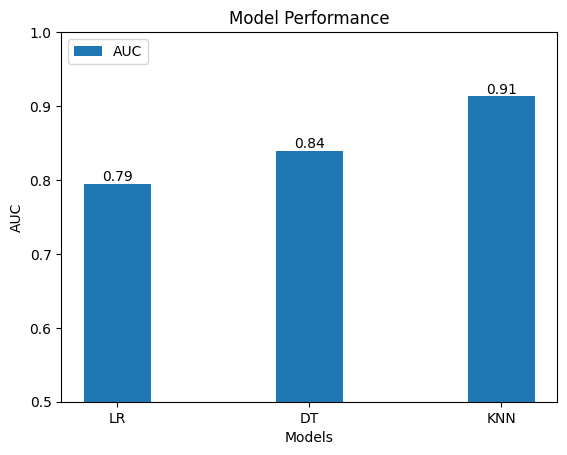

In [36]:
labels = ['LR', 'DT', 'KNN']

rg = np.arange(3)
width = 0.35

fig, ax = plt.subplots()
bars = ax.bar(rg, roc_scores, width, label="AUC")

# Adding labels on top of each bar
for bar, score in zip(bars, roc_scores):
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{score:.2f}', ha='center', va='bottom')

plt.xticks(rg, labels)
plt.xlabel("Models")
plt.ylabel("AUC")
plt.ylim([0.5, 1])

plt.title('Model Performance')
plt.legend(loc='upper left', ncol=2)
plt.show()